#Importing all The Libraries

In [10]:
pip install albumentations


  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/27/d1/98ac7a2d8cc826aff0ec1538e368346dc65bdada0cf39f6ebcd082f54dd1/albumentations-1.4.2-py3-none-any.whl.metadata
  Using cached albumentations-1.4.2-py3-none-any.whl.metadata (36 kB)
  Obtaining dependency information for scikit-image>=0.21.0 from https://files.pythonhosted.org/packages/ce/d0/a3f60c9f57ed295b3076e4acdb29a37bbd8823452562ab2ad51b03d6f377/scikit_image-0.22.0-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_image-0.22.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Obtaining dependency information for opencv-python-headless>=4.9.0 from https://files.pythonhosted.org/packages/20/44/458a0a135866f5e08266566b32ad9a182a7a059a894effe6c41a9c841ff1/opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Obtaining dependency information for imageio>=2.27 from https://files.python

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Lenovo\\anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [11]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob



In [12]:
#adding some more libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from pathlib import Path

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm


In [13]:
pip install albumentations > /dev/null 2>&1

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


In [14]:
pip install pretrainedmodels > /dev/null 2>&1


Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


In [15]:
import albumentations
import pretrainedmodels

ModuleNotFoundError: No module named 'albumentations'


#Preparing the data

In [13]:
# read the csv data files
train = pd.read_csv('train.csv')
test = pd.read_csv('test_vc2kHdQ.csv')
submit = pd.read_csv('sample_submission_yxjOnvz.csv')

In [14]:
train.shape, test.shape


((1646, 2), (706, 1))

In [15]:
train.groupby('emergency_or_not').count()


image_names
emergency_or_not             
0                         965
1                         681

<Axes: xlabel='emergency_or_not', ylabel='count'>

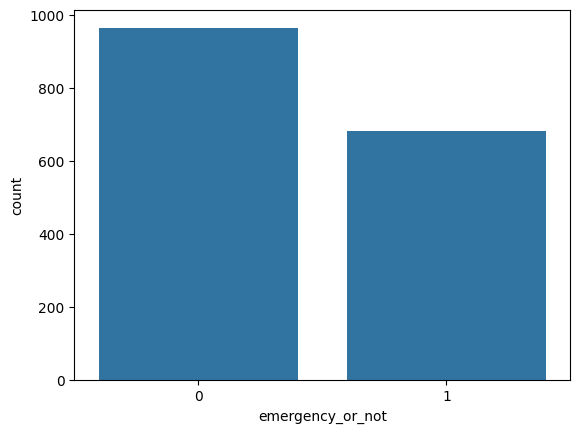

In [16]:
sns.countplot(x='emergency_or_not' , data=train)


###Here are the folder from which we can access the image for classification

In [17]:
## set the data folder
data_folder = Path("../input/janatahack-av-computervision")
data_path = "/content/images/"

path = os.path.join(data_path , "*jpg")

In [18]:
data_path

'/content/images/'

In [19]:
files = glob.glob(path)
data=[]
for file in files:
    image = cv2.imread(file)
    data.append(image)

In [20]:
train_images = data[:1646]
test_images= data[1646:]

In [21]:
# Print the shape of the first image in the dataset
print(train_images[0].shape)

# Check the number of images in the dataset
print(len(train_images))

# Print the shape of the last image in the dataset
print(train_images[-1].shape)


IndexError: list index out of range

In [39]:
def get_images_class(cat):
    list_of_images = []
    fetch = train.loc[train['emergency_or_not']== cat][:3].reset_index()
    for i in range(0,len(fetch['image_names'])):
        list_of_images.append(fetch['image_names'][i])
    return list_of_images

In [40]:
get_images_class(0)


['1503.jpg', '1420.jpg', '1764.jpg']

In [41]:
get_images_class(1)


['45.jpg', '294.jpg', '588.jpg']

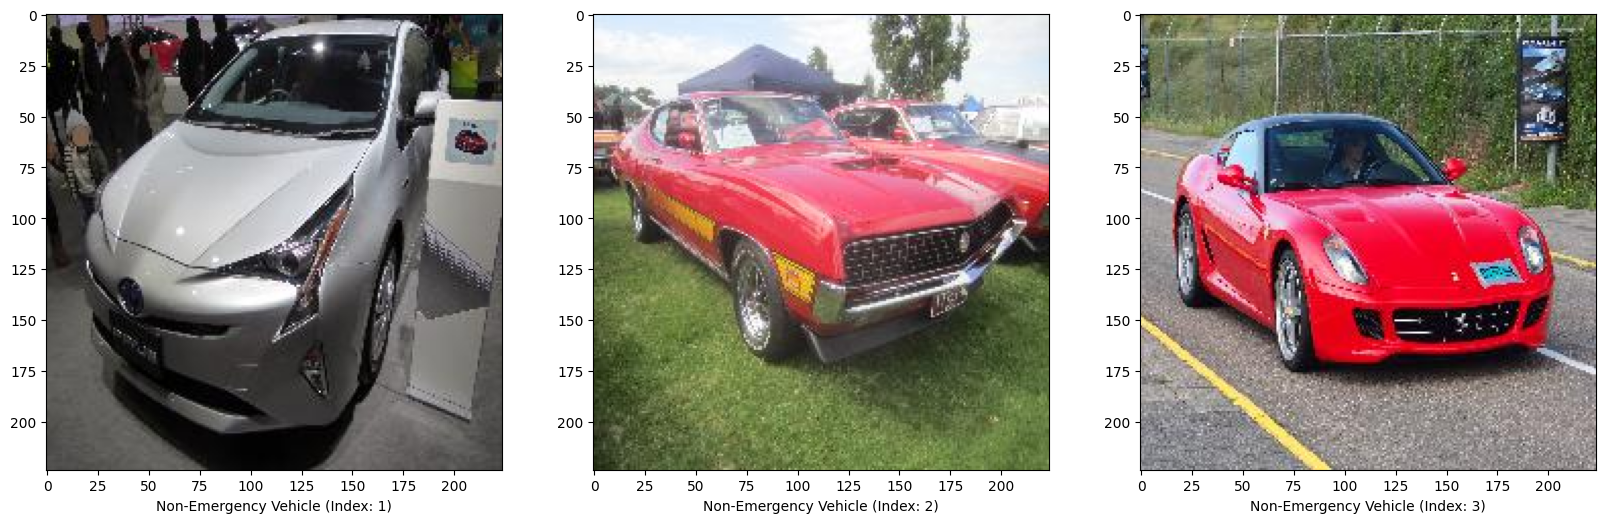

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming get_images_class(0) returns a list of image filenames
fig = plt.figure(figsize=(20, 15))
for i, image_name in enumerate(get_images_class(0)):
    plt.subplot(1, 3, i + 1)
    # Make sure to include a "/" before appending image_name
    img = mpimg.imread('/content/images/' + image_name)
    imgplot = plt.imshow(img)
    plt.xlabel("Non-Emergency Vehicle (Index: " + str(i + 1) + ")")
plt.show()


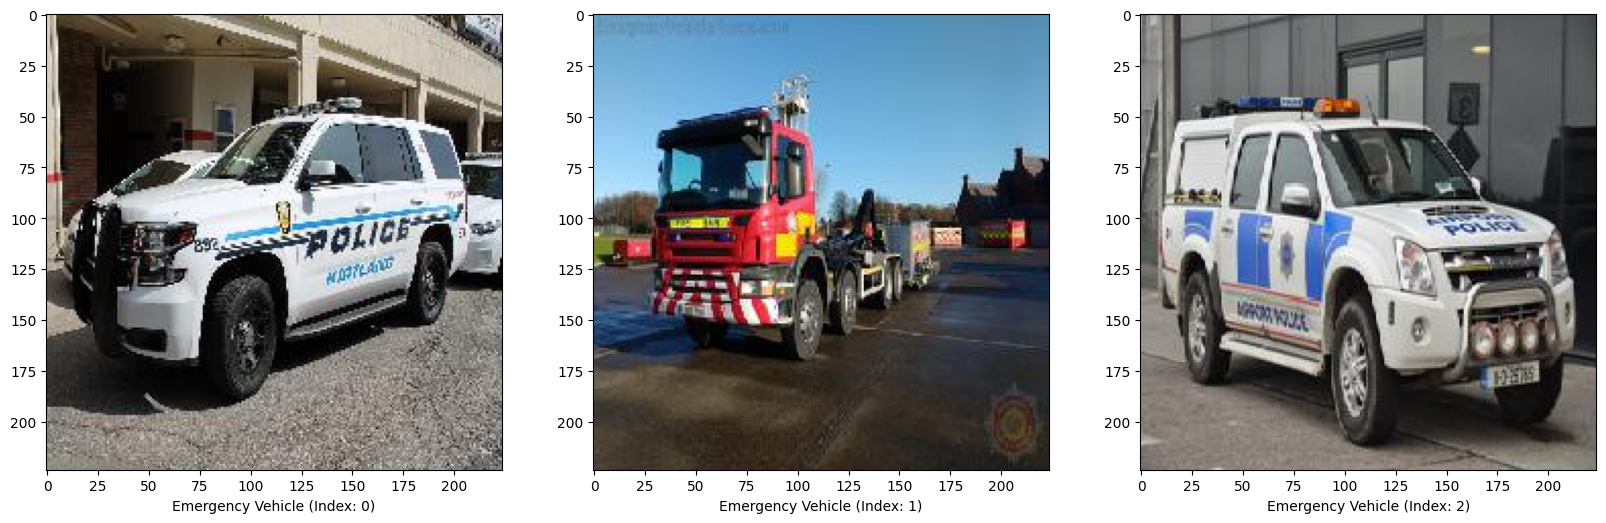

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(20, 15))
for i, image_name in enumerate(get_images_class(1)):
    plt.subplot(1, 3, i + 1)
    img = mpimg.imread('/content/images/' + image_name)
    imgplot = plt.imshow(img)
    plt.xlabel("Emergency Vehicle (Index: " + str(i) + ")")
plt.show()


In [51]:
class EmergencyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image_names'], row['emergency_or_not']
        img_fname = self.root_dir + str(img_id)
#         + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [68]:
TRAIN_CSV = 'train.csv'
transform = transforms.Compose([transforms.ToTensor()])
dataset = EmergencyDataset(TRAIN_CSV, data_path, transform=transform)

In [69]:
torch.manual_seed(10)

val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [70]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1317, 329)

In [71]:
batch_size = 32


In [72]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [73]:
dataset = EmergencyDataset(TRAIN_CSV, data_path, transform=transform)


In [74]:
train_loader  = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [75]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*4*4,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.sig = nn.Sigmoid()


    def forward(self, x):

        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))

        x = x.view(x.size(0), -1)


        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.sig(self.fc3(x))
        return x

In [76]:
model = Net() # On CPU
#model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [77]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [78]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [79]:
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/20], Step [0/42], Loss: 0.6884
Epoch [1/20], Step [20/42], Loss: 0.6721
Epoch [1/20], Step [40/42], Loss: 0.6618

train loss: 0.6762, train acc: 60.5163
validation loss: 0.7286, validation acc: 41.3374

Detected network improvement, saving current model
Epoch 2

Epoch [2/20], Step [0/42], Loss: 0.6356
Epoch [2/20], Step [20/42], Loss: 0.6116
Epoch [2/20], Step [40/42], Loss: 0.5957

train loss: 0.6496, train acc: 70.0835
validation loss: 0.7205, validation acc: 41.6413

Detected network improvement, saving current model
Epoch 3

Epoch [3/20], Step [0/42], Loss: 0.5661
Epoch [3/20], Step [20/42], Loss: 0.5184
Epoch [3/20], Step [40/42], Loss: 0.5666

train loss: 0.6207, train acc: 75.5505
validation loss: 0.6945, validation acc: 63.5258

Detected network improvement, saving current model
Epoch 4

Epoch [4/20], Step [0/42], Loss: 0.5186
Epoch [4/20], Step [20/42], Loss: 0.5271
Epoch [4/20], Step [40/42], Loss: 0.5289

train loss: 0.5974, train acc: 79.3470
validation loss: 0.671

##Accuracy and Loss Curve

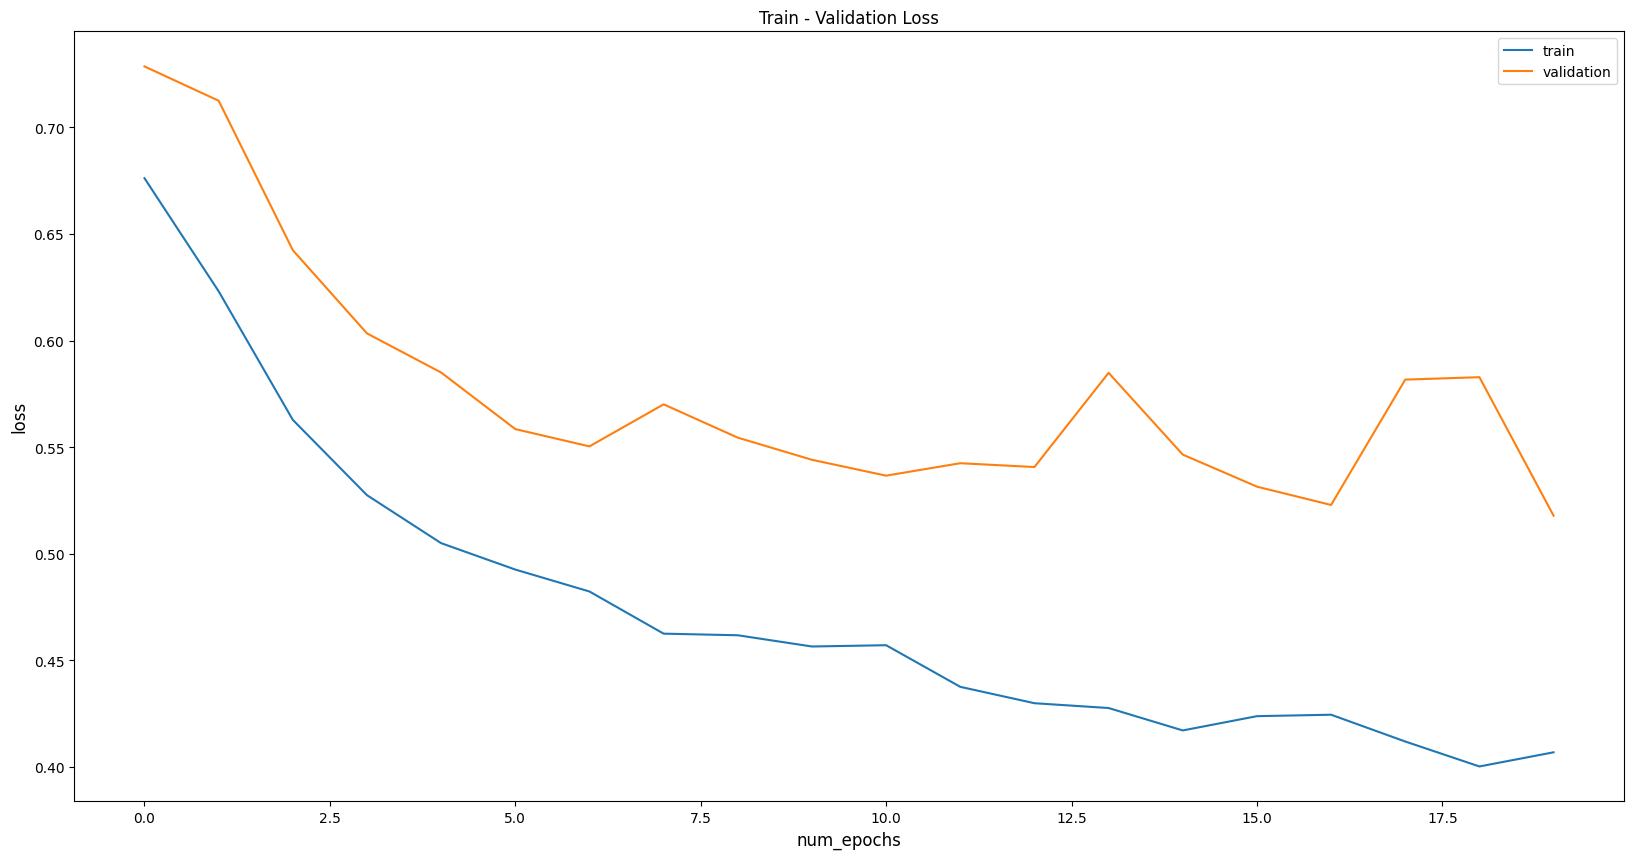

In [80]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

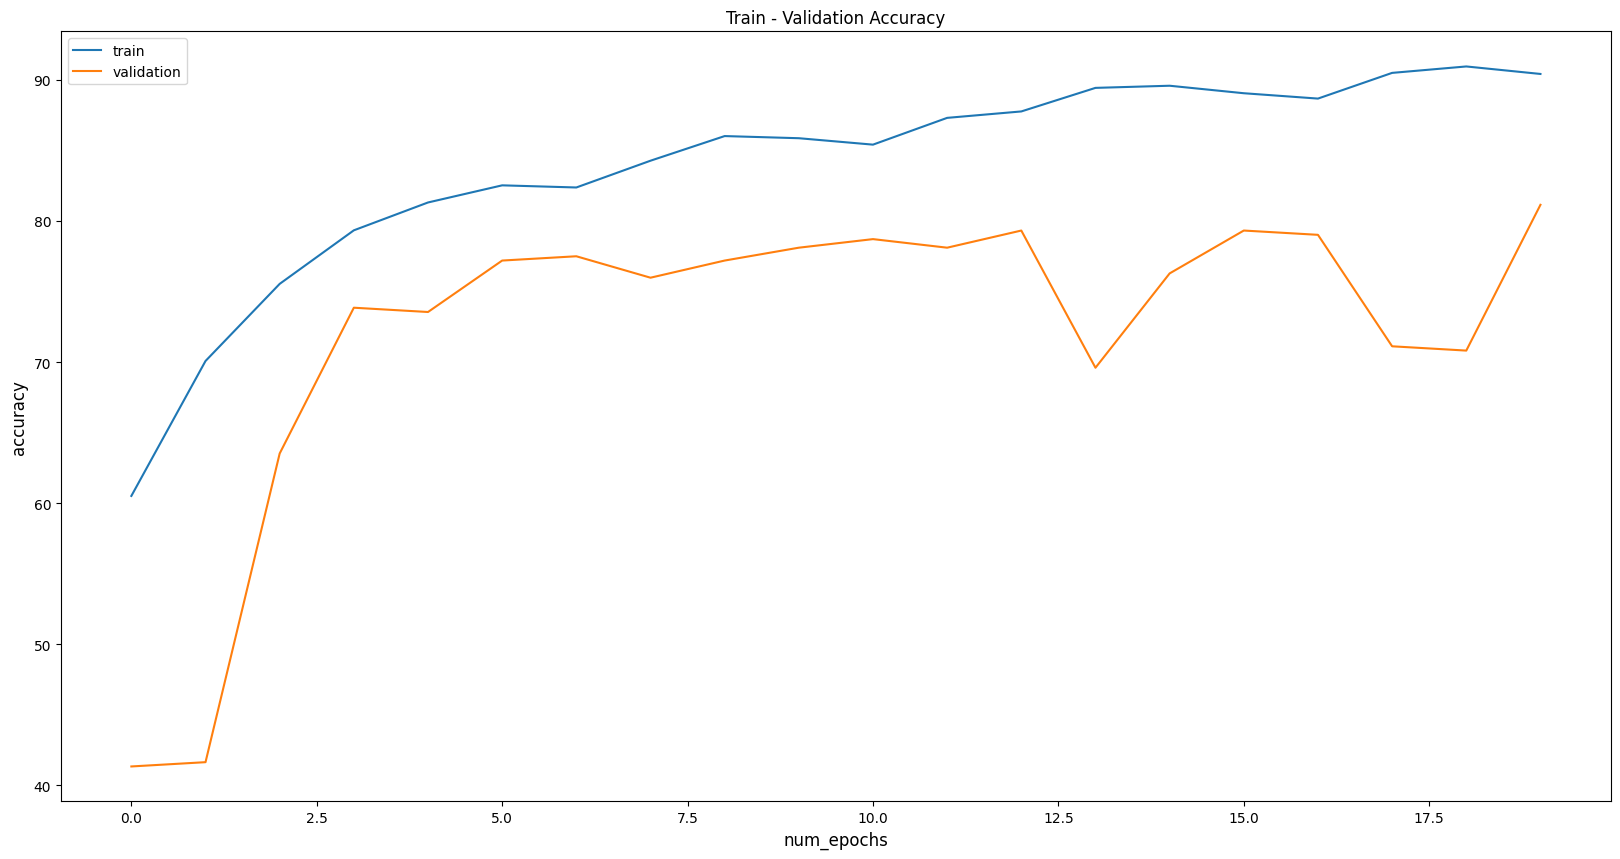

In [81]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [82]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification.pt'))

<All keys matched successfully>

##Evaluation

In [83]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

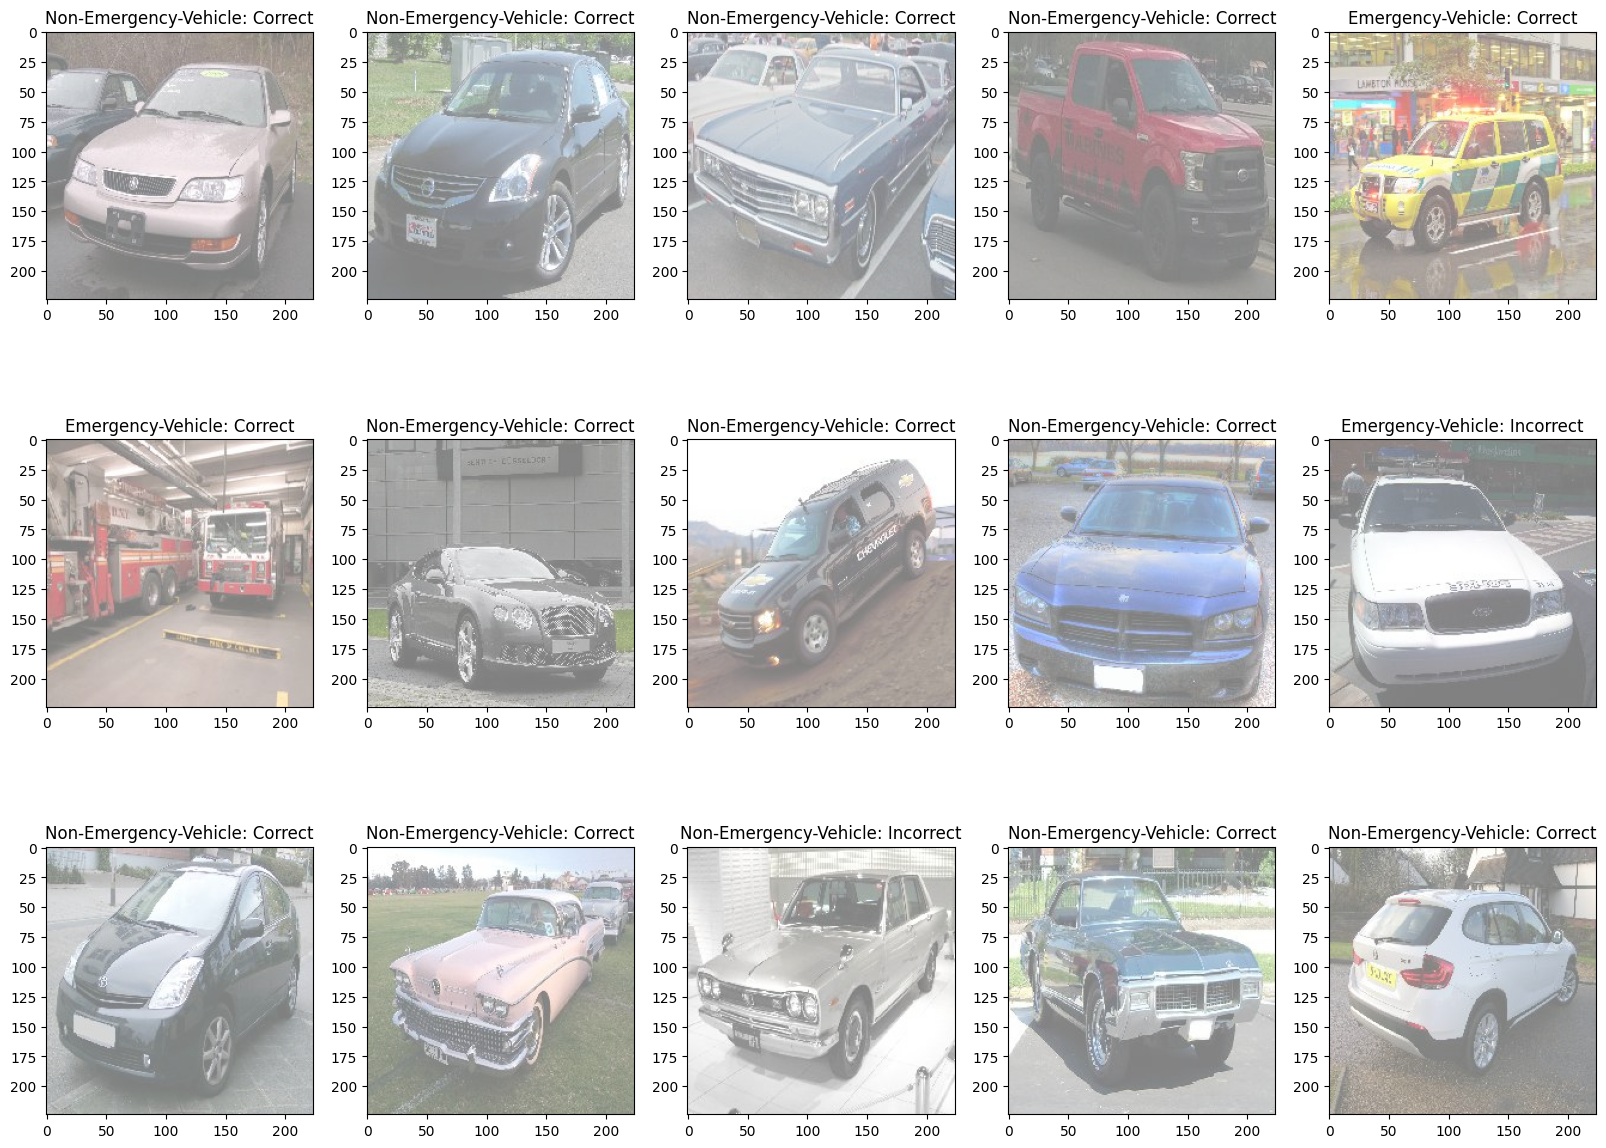

In [86]:
vehicle_types = {0: 'Non-Emergency-Vehicle', 1: 'Emergency-Vehicle'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(20, 15))
model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(validation_loader):
        if i >= 3:  # Display only the first 3 batches
            break
        for j, (image, label) in enumerate(zip(images, labels)):
            if j >= 5:  # Display only the first 5 images in each batch
                break
            ax = axis[i, j]
            ax.imshow(img_display(image))  # add image
            image_tensor = image.unsqueeze(0)
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            correct = (predicted == label).item()
            ax.set_title(f"{vehicle_types[label.item()]}: {'Correct' if correct else 'Incorrect'}")
plt.show()


##Submission on Test Set


In [87]:
TEST_CSV = 'sample_submission_yxjOnvz.csv'
test_dataset = EmergencyDataset(TEST_CSV, data_path, transform=transform)

In [88]:
len(test_dataset)


706

In [89]:
test_dl = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)


In [90]:
test_dl


In [91]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)

    return [x.numpy() for x in batch_probs]

In [92]:
submission_df = pd.read_csv(TEST_CSV)
test_preds = predict_dl(test_dl, model)
submission_df.emergency_or_not = np.argmax(test_preds, axis = 1)
submission_df.head()

  0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


image_names  emergency_or_not
0    1960.jpg                 0
1     668.jpg                 1
2    2082.jpg                 0
3     808.jpg                 0
4    1907.jpg                 0

In [93]:
submission_df.tail()


image_names  emergency_or_not
701     674.jpg                 0
702    1027.jpg                 0
703     447.jpg                 0
704    2176.jpg                 0
705    1014.jpg                 0

In [94]:
submission_df['emergency_or_not'].value_counts()


0    701
1      5
Name: emergency_or_not, dtype: int64

In [95]:
submission_df.to_csv('submission.csv', index=False)


In [96]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_dl):
#     data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
submission_df['emergency_or_not'] = submission_df['emergency_or_not'].apply(lambda x: 1 if x >= 0.5 else 0)
submission_df.to_csv('submission_output.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [97]:
submission_df.head()


image_names  emergency_or_not
0    1960.jpg                 0
1     668.jpg                 1
2    2082.jpg                 0
3     808.jpg                 0
4    1907.jpg                 0

In [98]:
submission_df['emergency_or_not'].value_counts()


0    701
1      5
Name: emergency_or_not, dtype: int64

In [99]:
print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')


validation loss: 0.5769, validation acc: 81.1550



In [100]:
## function to create download link
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "submission_output.csv"):
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [101]:
create_download_link(filename = 'submission_output.csv')
